# http://172.18.30.162:18907/lab?

### Basic Imports

### pip install git+https://github.com/openai/CLIP.git

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.datasets import coco
from torchvision.datasets import mnist
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip
from skimage import io
import matplotlib.pyplot as plt


# # random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# # Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the modelClip
modelClip, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/data/lab/lab03/clip/')
modelClip.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     


### Dataset


Files already downloaded and verified
Files already downloaded and verified
the performance on CIFAR10 is 54.95%, visual encoder is RN50.


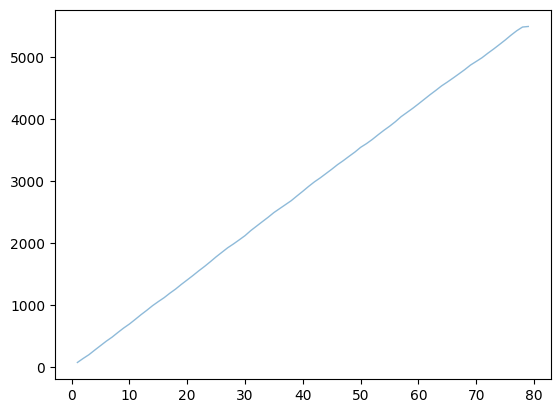

In [2]:
transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set1 = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_cifar10_train)
train_dataloader1 = torch.utils.data.DataLoader(train_set1, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set1 = torchvision.datasets.CIFAR10(root='/data', train=False, download=True, transform=transform_cifar10_test)
test_dataloader1 = torch.utils.data.DataLoader(test_set1, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'

prompt = "asdqwedqwdwda"
text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

def modelClip_inference(modelClip, image):
    image_features = modelClip.encode_image(image)
    text_features = modelClip.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = modelClip.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()
    
    return logits

testing_loss = []
testing_acc = []

with torch.no_grad():
    modelClip.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader1):

            
        image = image.to(device)
        target = target.to(device)

        # test modelClip
        logits = modelClip_inference(modelClip, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)
        testing_acc.append(val_corrects.cpu().numpy())

    val_acc = val_corrects.double() / len(test_set1)

    print(f"the performance on CIFAR10 is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
    
x_axis_data = np.arange(1, 80, 1)
y_axis_data = testing_acc

plt.plot(x_axis_data, y_axis_data, alpha=0.5, linewidth=1, label='acc')

Files already downloaded and verified
Files already downloaded and verified
the performance on CIFAR100 is 0.63%, visual encoder is RN50.


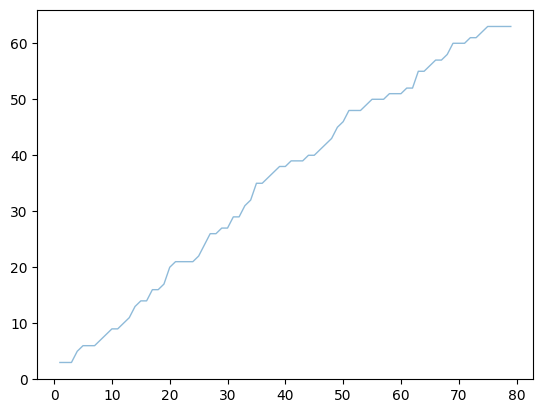

In [3]:
transform_cifar100_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar100_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set2 = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=transform_cifar100_train)
train_dataloader2 = torch.utils.data.DataLoader(train_set2, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set2 = torchvision.datasets.CIFAR100(root='/data', train=False, download=True, transform=transform_cifar100_test)
test_dataloader2 = torch.utils.data.DataLoader(test_set2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

dataset_name = 'CIFAR100'
class_names = np.arange(0,100,1)

prompt = "asdqwedqwdwda"
text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

def modelClip_inference(modelClip, image):
    image_features = modelClip.encode_image(image)
    text_features = modelClip.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = modelClip.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()
    
    return logits

testing_loss = []
testing_acc = []

with torch.no_grad():
    modelClip.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader2):

            
        image = image.to(device)
        target = target.to(device)

        # test modelClip
        logits = modelClip_inference(modelClip, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)
        
        testing_acc.append(val_corrects.cpu().numpy())

    val_acc = val_corrects.double() / len(test_set2)

    print(f"the performance on CIFAR100 is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
    
x_axis_data = np.arange(1, 80, 1)
y_axis_data = testing_acc

plt.plot(x_axis_data, y_axis_data, alpha=0.5, linewidth=1, label='acc')

Files already downloaded and verified
Files already downloaded and verified
the performance on STL10 is 7.88%, visual encoder is RN50.


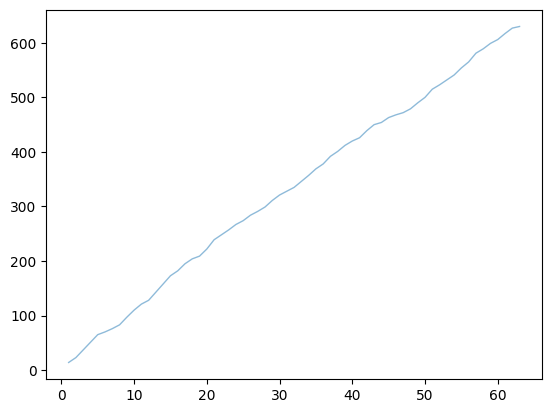

In [4]:
transform_stl10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_stl10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set3 = torchvision.datasets.STL10(root='../data', split='train', download=True, transform=transform_stl10_train)
train_dataloader3 = torch.utils.data.DataLoader(train_set3, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set3 = torchvision.datasets.STL10(root='/data', split='test', download=True, transform=transform_stl10_test)
test_dataloader3 = torch.utils.data.DataLoader(test_set3, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ['1','2','3','4','5','6','7','8','9','0']
dataset_name = 'STL10'

prompt = "asdqwedqwdwda"
text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

def modelClip_inference(modelClip, image):
    image_features = modelClip.encode_image(image)
    text_features = modelClip.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = modelClip.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()
    
    return logits

testing_loss = []
testing_acc = []

with torch.no_grad():
    modelClip.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader3):

            
        image = image.to(device)
        target = target.to(device)

        # test modelClip
        logits = modelClip_inference(modelClip, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)
        testing_acc.append(val_corrects.cpu().numpy())

    val_acc = val_corrects.double() / len(test_set3)

    print(f"the performance on STL10 is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
    
x_axis_data = np.arange(1, 64, 1)
y_axis_data = testing_acc

plt.plot(x_axis_data, y_axis_data, alpha=0.5, linewidth=1, label='acc')